In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cvx
import skimage as ski

import skimage.io
import skimage.transform

import scipy.fftpack as spfft

# Image Compression

Original size:  (292, 228)
Rescaled size:  (53, 41)


C:\Users\King48\AppData\Local\Temp/ipykernel_65484/1563462800.py:5: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  img_og = ski.color.rgb2gray(img_og)


(-0.5, 40.5, 52.5, -0.5)

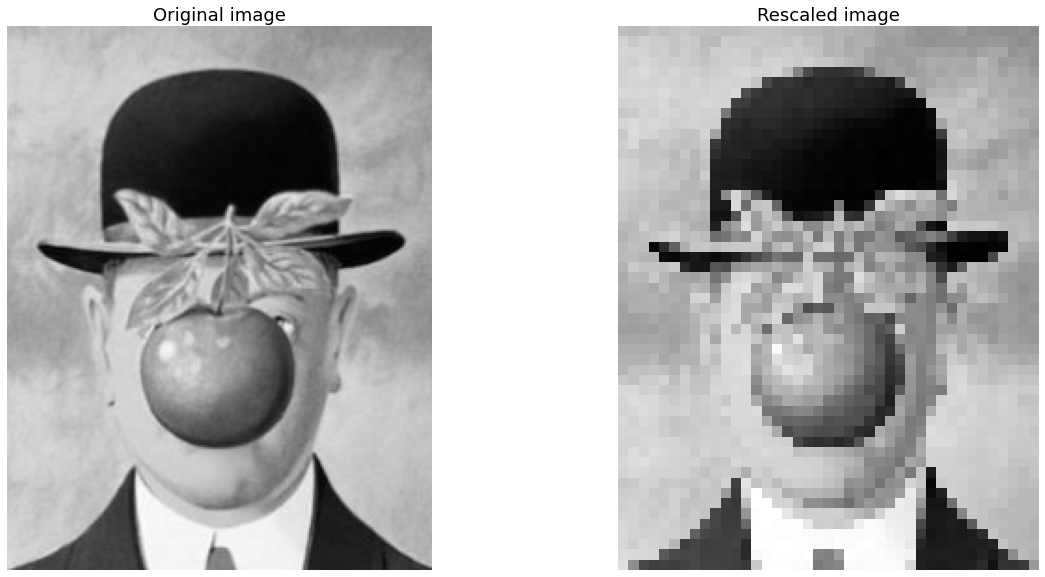

In [10]:
img_path = 'SonOfMan.png'

img_og = ski.io.imread(img_path)

img_og = ski.color.rgb2gray(img_og)

fig, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].imshow(img_og, cmap = 'gray')
ax[0].set_title("Original image", fontsize=18)
ax[0].axis('off')

print("Original size: ", img_og.shape)

img = ski.transform.rescale(img_og, 0.18, anti_aliasing=False)

print("Rescaled size: ", img.shape)

ax[1].imshow(img, cmap='gray')
ax[1].set_title("Rescaled image", fontsize=18)
ax[1].axis('off')

In [3]:
def construct_DCT_Mat(Nx, Ny):

  Dx = spfft.dct(np.eye(Nx), axis =0, norm='ortho')

  Dy = spfft.dct(np.eye(Ny), axis = 0, norm='ortho')

  D = np.kron(Dy, Dx)

  return D

def construct_iDCT_Mat(Nx, Ny):

  Dx = spfft.idct(np.eye(Nx), axis =0, norm='ortho')

  Dy = spfft.idct(np.eye(Ny), axis = 0, norm = 'ortho')

  D = np.kron(Dy, Dx)

  return D

In [4]:
Nx = img.shape[1]
Ny = img.shape[0]

DCT_mat = construct_DCT_Mat(Nx, Ny)
iDCT_mat = construct_iDCT_Mat(Nx, Ny)

vec_F = img.flatten()

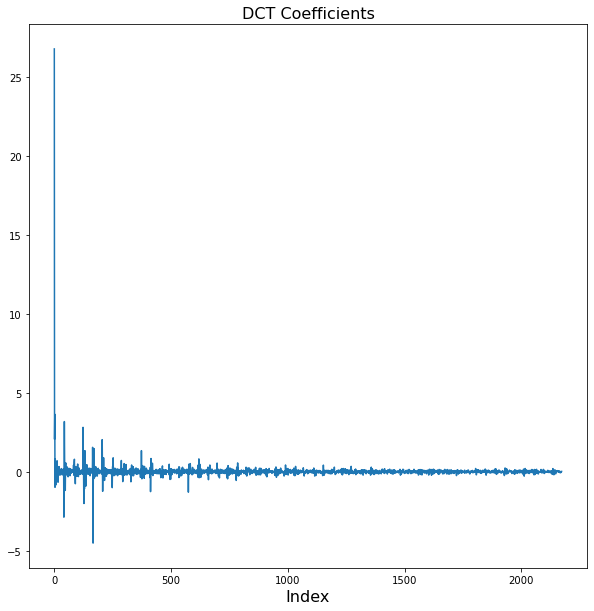

In [12]:
DCT_img = np.dot(DCT_mat, vec_F)

plt.figure(figsize=(10, 10))
plt.plot(DCT_img)
plt.xlabel('Index', fontsize=16)
plt.title('DCT Coefficients', fontsize=16)
plt.show()

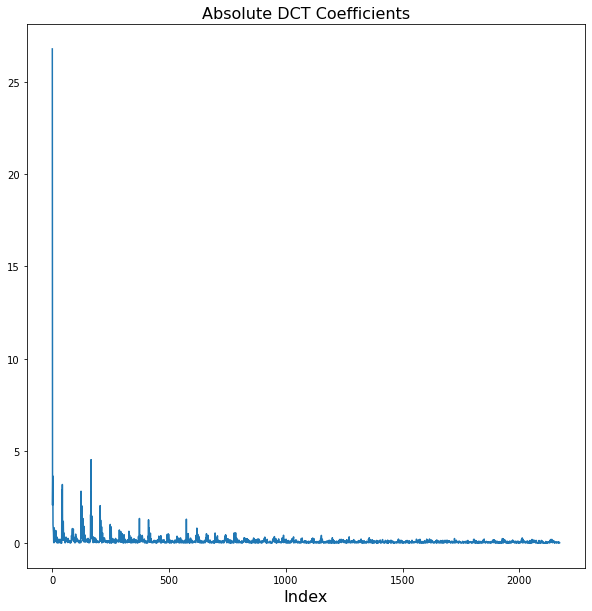

In [13]:
DCT_img = np.dot(DCT_mat, vec_F)

plt.figure(figsize=(10, 10))
plt.plot(np.abs(DCT_img))
plt.xlabel('Index', fontsize=16)
plt.title('Absolute DCT Coefficients', fontsize=16)
plt.show()

In [6]:
magnitude_5 = np.percentile(np.abs(DCT_img), 100 - 5)
magnitude_10 = np.percentile(np.abs(DCT_img), 100 - 10)
magnitude_20 = np.percentile(np.abs(DCT_img), 100 - 20)
magnitude_40 = np.percentile(np.abs(DCT_img), 100 - 40)

thresholded_DCT_5 = np.where(np.abs(DCT_img) >= magnitude_5, DCT_img, 0)
thresholded_DCT_10 = np.where(np.abs(DCT_img) >= magnitude_10, DCT_img, 0)
thresholded_DCT_20 = np.where(np.abs(DCT_img) >= magnitude_20, DCT_img, 0)
thresholded_DCT_40 = np.where(np.abs(DCT_img) >= magnitude_40, DCT_img, 0)

Re_img_5 = np.dot(iDCT_mat, thresholded_DCT_5)
Re_img_10 = np.dot(iDCT_mat, thresholded_DCT_10)
Re_img_20 = np.dot(iDCT_mat, thresholded_DCT_20)
Re_img_40 = np.dot(iDCT_mat, thresholded_DCT_40)

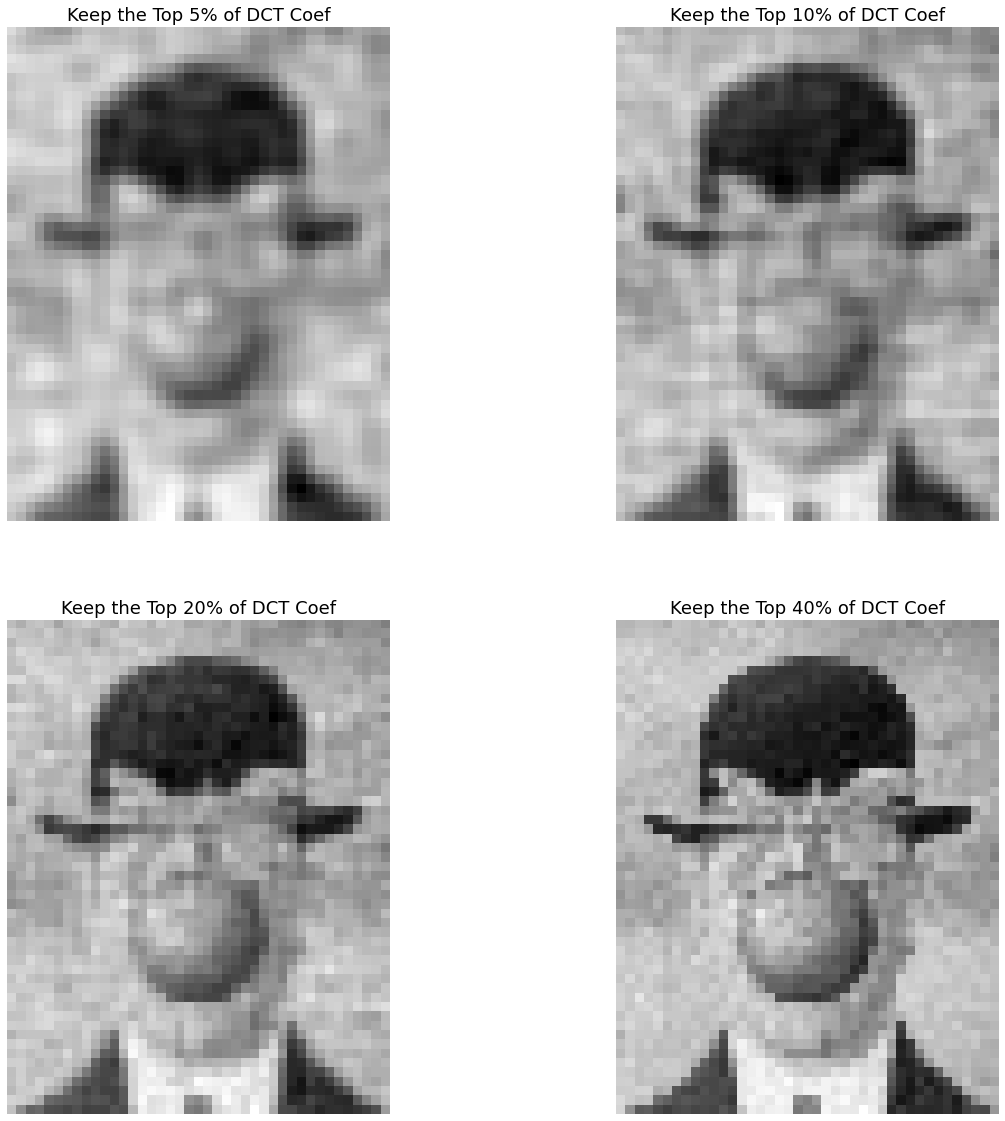

In [9]:
Re = [Re_img_5, Re_img_10, Re_img_20, Re_img_40]
Titles = ['5%', '10%', '20%', '40%']

fig, ax = plt.subplots(2, 2, figsize=(20,20))
for i in range(2):
    for j in range(2):
        ax[i][j].imshow(Re[i*2+j].reshape(53, 41), cmap='gray')
        ax[i][j].axis('off')
        ax[i][j].set_title('Keep the Top ' + Titles[i*2+j] + ' of DCT Coef', fontsize=18)
plt.show()

# Compressed Image Recovery

In [8]:
def construct_Measurement_Mat(M, N):

    i_mat = np.identity(N)
    sample_rows = np.random.permutation(N)
    B = i_mat[sample_rows[:M], :]

    return B

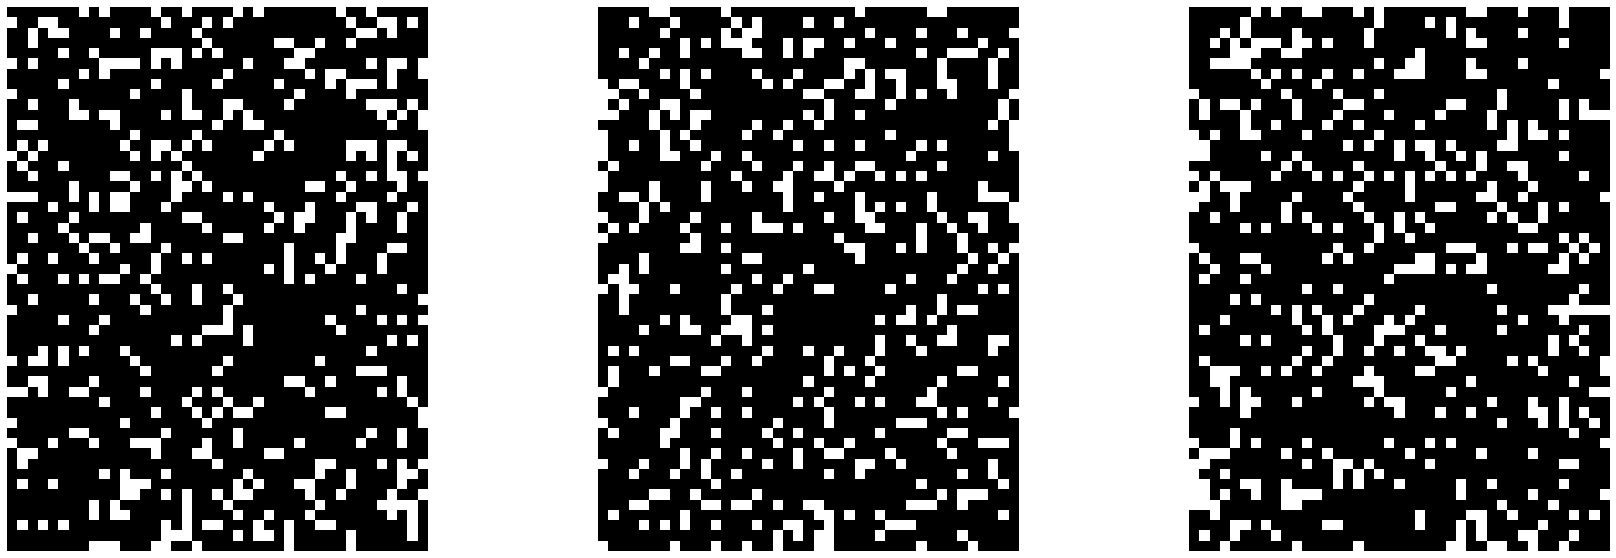

In [9]:
N = len(vec_F)
M = round(0.2 * N)
Bs = []

fig, ax = plt.subplots(1, 3, figsize=(30,10))
for i in range(3):
    B = construct_Measurement_Mat(M, N)
    ax[i].imshow(np.reshape(np.sum(B, axis = 0), (Ny, Nx)), cmap='gray')
    ax[i].axis('off')
    Bs.append(B)

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) Mar 15 12:15:11 AM: Your problem has 2173 variables, 1 constraints, and 0 parameters.
(CVXPY) Mar 15 12:15:11 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 15 12:15:11 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 15 12:15:11 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 15 12:15:11 AM: Compiling problem (target solver=CVXOPT).
(CVXPY) Mar 15 12:15:11 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffin

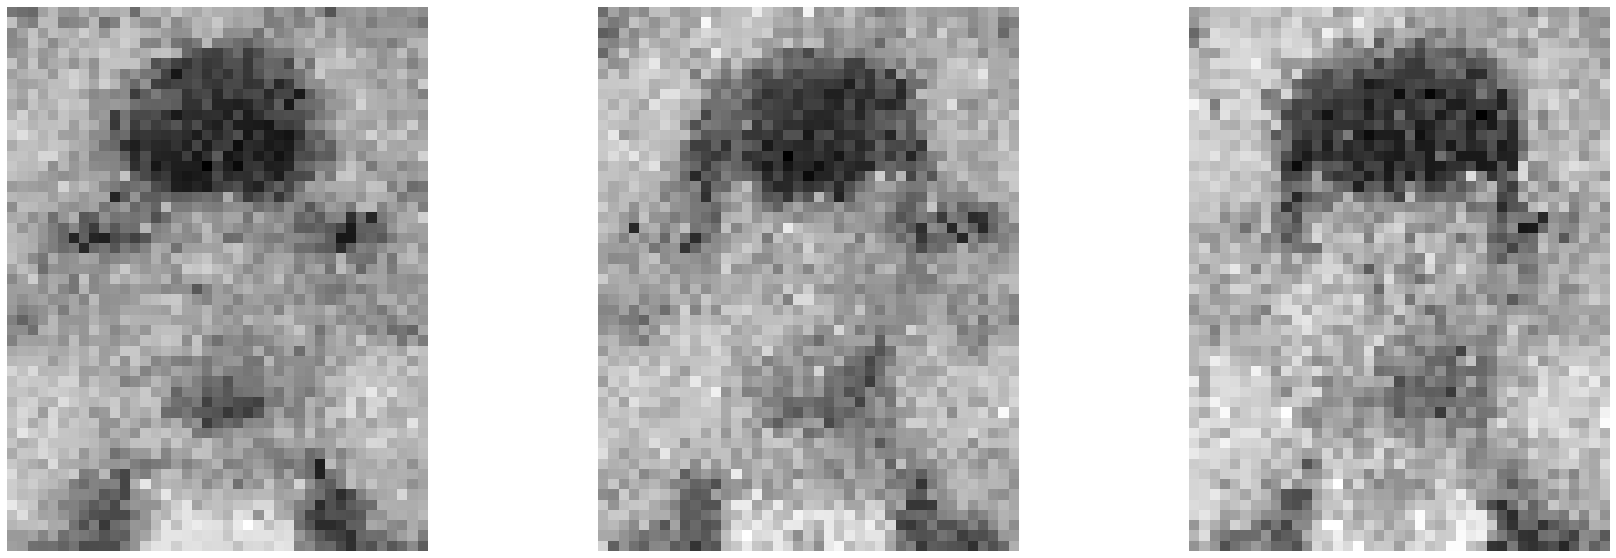

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))
for i in range(3):
    B = Bs[i]
    y = np.dot(B, vec_F)
    A = np.dot(B, iDCT_mat)
    x = cvx.Variable(N)
    objective = cvx.Minimize(cvx.norm(x, 1))
    constraint = [A @ x == y]
    prob = cvx.Problem(objective, constraint)
    prob.solve(verbose=True, solver='CVXOPT', max_iter=1000, reltol=1e-2, featol=1e-2)
    re_img = np.dot(iDCT_mat, x.value).reshape(Ny, Nx)
    ax[i].imshow(re_img, cmap='gray')
    ax[i].axis('off')

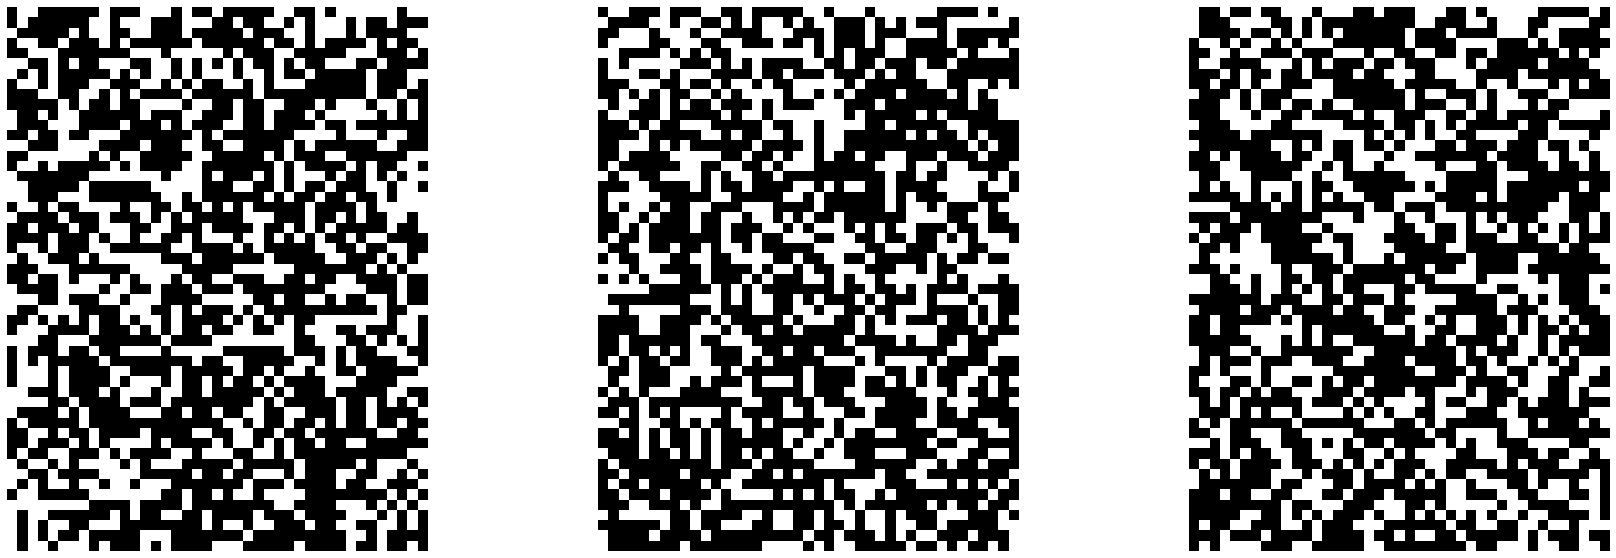

In [11]:
M = round(0.4 * N)
Bs = []

fig, ax = plt.subplots(1, 3, figsize=(30,10))
for i in range(3):
    B = construct_Measurement_Mat(M, N)
    ax[i].imshow(np.reshape(np.sum(B, axis = 0), (Ny, Nx)), cmap='gray')
    ax[i].axis('off')
    Bs.append(B)

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) Mar 15 12:19:41 AM: Your problem has 2173 variables, 1 constraints, and 0 parameters.
(CVXPY) Mar 15 12:19:41 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 15 12:19:41 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 15 12:19:41 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 15 12:19:41 AM: Compiling problem (target solver=CVXOPT).
(CVXPY) Mar 15 12:19:41 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffin

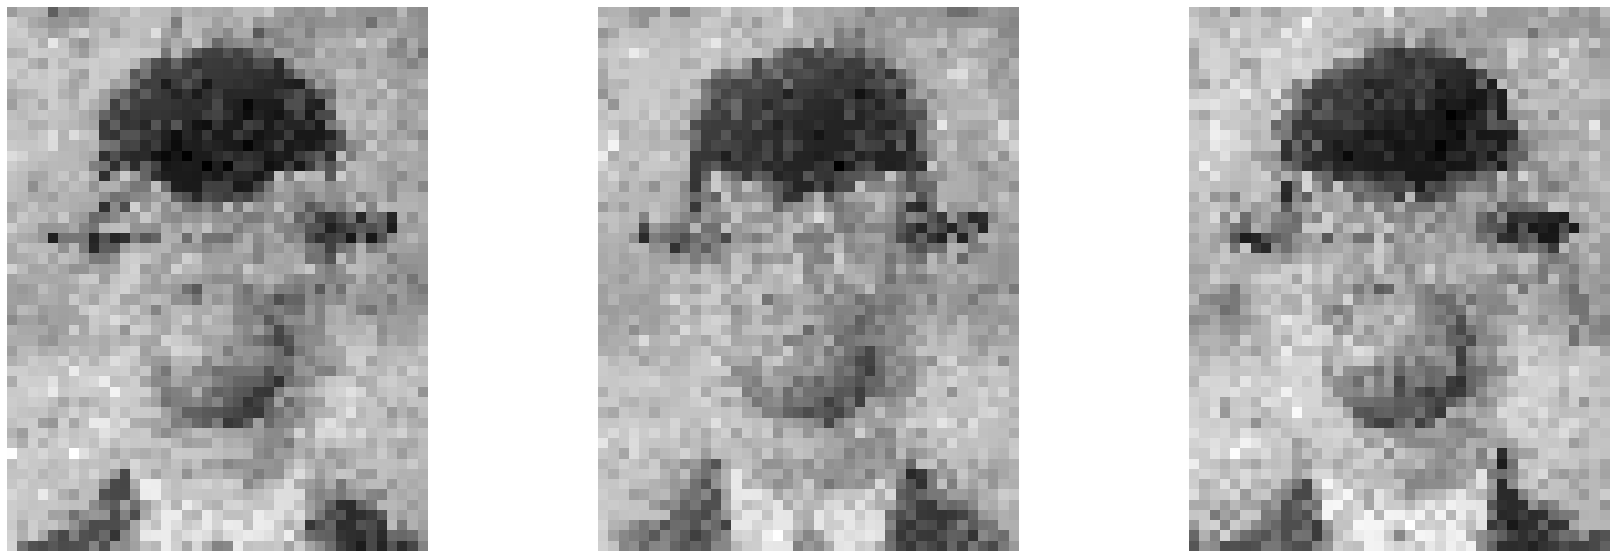

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))
for i in range(3):
    B = Bs[i]
    y = np.dot(B, vec_F)
    A = np.dot(B, iDCT_mat)
    x = cvx.Variable(N)
    objective = cvx.Minimize(cvx.norm(x, 1))
    constraint = [A @ x == y]
    prob = cvx.Problem(objective, constraint)
    prob.solve(verbose=True, solver='CVXOPT', max_iter=1000, reltol=1e-2, featol=1e-2)
    re_img = np.dot(iDCT_mat, x.value).reshape(Ny, Nx)
    ax[i].imshow(re_img, cmap='gray')
    ax[i].axis('off')

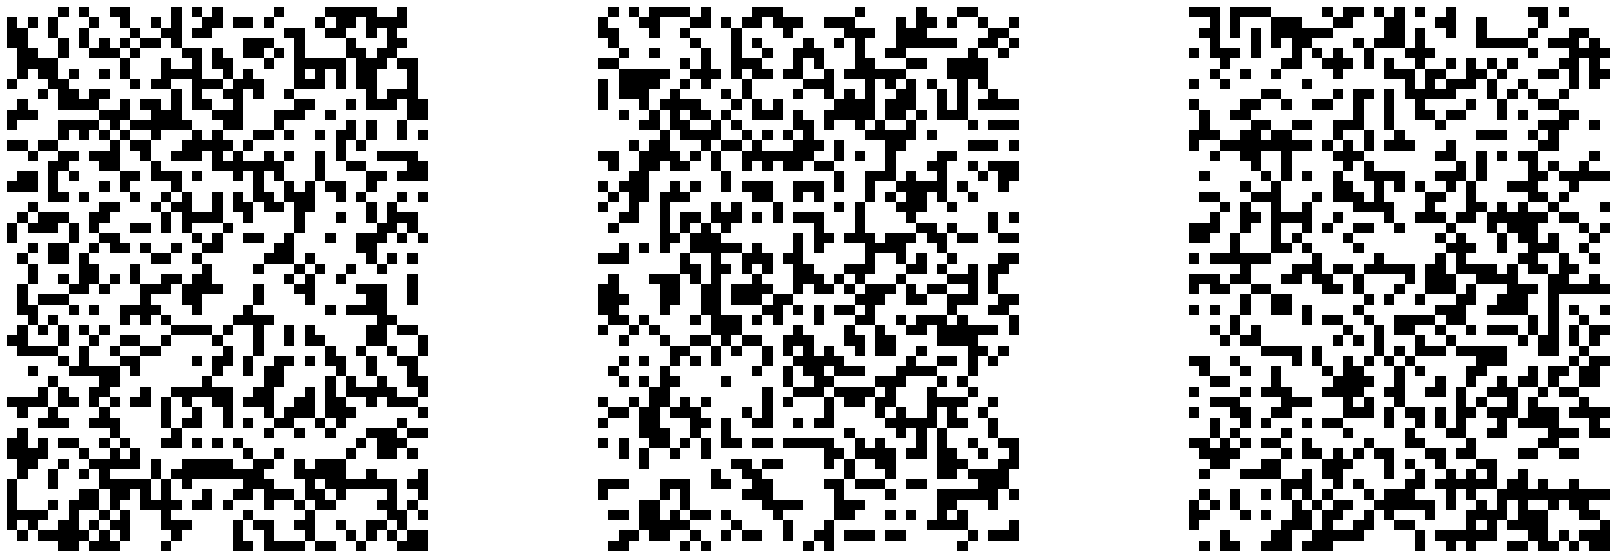

In [13]:
M = round(0.6 * N)
Bs = []

fig, ax = plt.subplots(1, 3, figsize=(30,10))
for i in range(3):
    B = construct_Measurement_Mat(M, N)
    ax[i].imshow(np.reshape(np.sum(B, axis = 0), (Ny, Nx)), cmap='gray')
    ax[i].axis('off')
    Bs.append(B)

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) Mar 15 12:24:25 AM: Your problem has 2173 variables, 1 constraints, and 0 parameters.
(CVXPY) Mar 15 12:24:25 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 15 12:24:25 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 15 12:24:25 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 15 12:24:25 AM: Compiling problem (target solver=CVXOPT).
(CVXPY) Mar 15 12:24:25 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffin

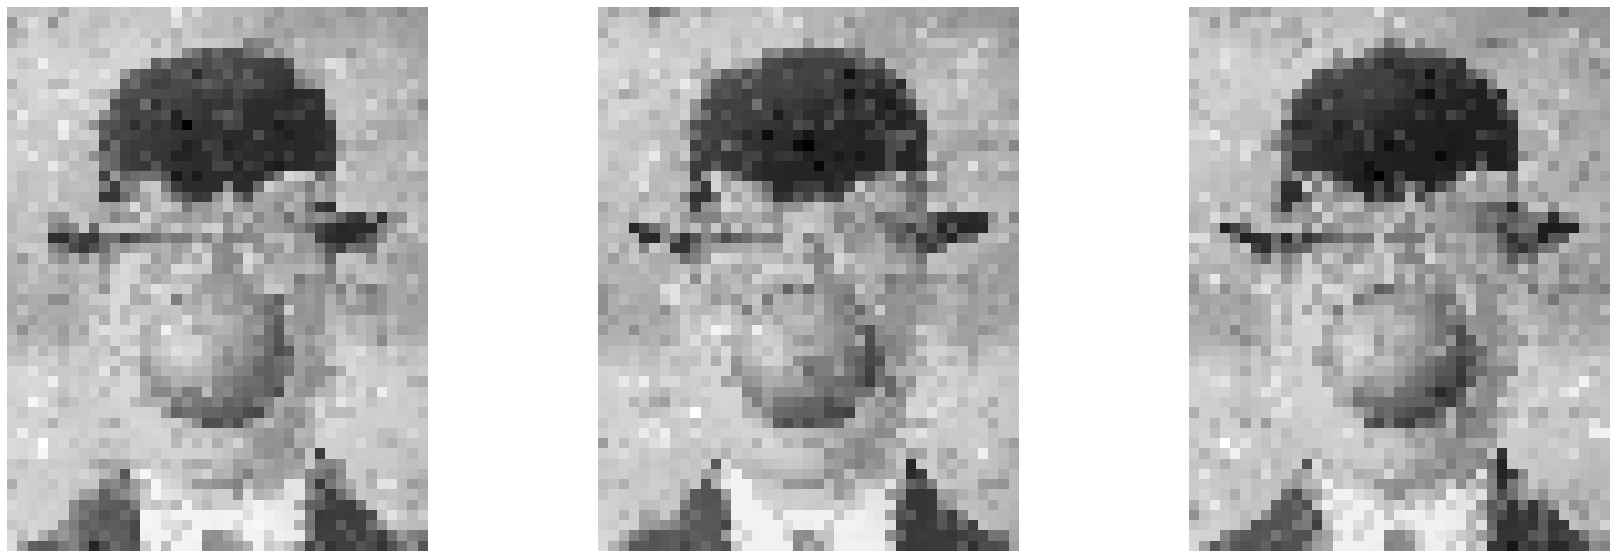

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))
for i in range(3):
    B = Bs[i]
    y = np.dot(B, vec_F)
    A = np.dot(B, iDCT_mat)
    x = cvx.Variable(N)
    objective = cvx.Minimize(cvx.norm(x, 1))
    constraint = [A @ x == y]
    prob = cvx.Problem(objective, constraint)
    prob.solve(verbose=True, solver='CVXOPT', max_iter=1000, reltol=1e-2, featol=1e-2)
    re_img = np.dot(iDCT_mat, x.value).reshape(Ny, Nx)
    ax[i].imshow(re_img, cmap='gray')
    ax[i].axis('off')

# A Mysterious Image

In [18]:
data = np.load('UnknownImage.npz')
B = data['B']
y = data['y']

In [19]:
N = 50*50
iDCT_unknown = construct_iDCT_Mat(50, 50)
A = np.dot(B, iDCT_unknown)
x = cvx.Variable(N)
objective = cvx.Minimize(cvx.norm(x, 1))
constraint = [A @ x == y]
prob = cvx.Problem(objective, constraint)
prob.solve(verbose=True, solver='CVXOPT', max_iter=1000, reltol=1e-2, featol=1e-2)
re_unknown = np.dot(iDCT_unknown, x.value).reshape(50, 50)

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) Mar 15 12:39:25 AM: Your problem has 2500 variables, 1 constraints, and 0 parameters.
(CVXPY) Mar 15 12:39:25 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 15 12:39:25 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 15 12:39:25 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 15 12:39:25 AM: Compiling problem (target solver=CVXOPT).
(CVXPY) Mar 15 12:39:25 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffin

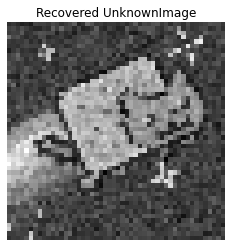

In [21]:
plt.imshow(re_unknown, cmap='gray')
plt.title('Recovered UnknownImage')
plt.axis('off')
plt.show()

# Nyan Cat!!!